In [157]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from aldiscore.prediction import utils
from aldiscore import ROOT

In [162]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, *_ = utils.load_features(
    data_dir,
    include_features=["is_dna", "num_seqs", "seq_length"],
)
# feat_df.columns = clean_feat_names
print(feat_df.shape)
feat_df = feat_df[["is_dna", "num_seqs", "max.seq_length"]]
feat_df.head()

Dropping 0 NaN rows...
(11431, 21)


is_dna  num_seqs  max.seq_length
source    dataset                                  
arthropod CYP_12    False       141             558
          CYP_15    False       148             524
          CYP_18    False       124             569
          CYP_2     False        16             544
          CYP_20    False        19             494

In [163]:
perf_dir = ROOT.parent / "logs" / "perf"
perf_file = sorted(os.listdir(perf_dir))[-1]
print(perf_file)
perf_df = pd.read_parquet(perf_dir / perf_file)
# perf_df = pd.concat([perf_df, feat_df], axis=1)
perf_df

2025-10-13_15-29-23_n600.parquet


_init_basics  \
source        dataset                                            
treebase_v1   21420_1.phy                             0.010569   
              21918_2.phy                             0.014376   
              14688_14.phy                            0.016690   
              17890_0.phy                             0.017128   
              378_2.phy                               0.009659   
...                                                        ...   
bralibase_k15 5S_rRNA.apsi-56.sci-94.no-1             0.001990   
              IRES_HCV.apsi-88.sci-67.no-2            0.002439   
              Retroviral_psi.apsi-91.sci-76.no-1      0.002172   
              TAR.apsi-89.sci-89.no-1                 0.002110   
              SRP_bact.apsi-50.sci-92.no-1            0.002194   

                                                  _init_char_dists  _init_psa  \
source        dataset                                                           
treebase_v1   21420_1.phy                                 0.000544   0.013343   
              21918_2.phy                                 0.000693   0.111166   
              14688_14.phy                                0.001182   0.071348   
              17890_0.phy                                 0.001742   0.229266   
              378_2.phy                                   0.001081   0.292386   
...                                                            ...        ...   
bralibase_k15 5S_rRNA.apsi-56.sci-94.no-1                 0.000399   0.041105   
              IRES_HCV.apsi-88.sci-67.no-2                0.000684   0.090877   
              Retroviral_psi.apsi-91.sci-76.no-1          0.000421   0.035263   
              TAR.apsi-89.sci-89.no-1                     0.000329   0.013813   
              SRP_bact.apsi-50.sci-92.no-1                0.000374   0.029484   

                                                  _init_psa_index_map  \
source        dataset                                                   
treebase_v1   21420_1.phy                                    0.002167   
              21918_2.phy                                    0.002114   
              14688_14.phy                                   0.007137   
              17890_0.phy                                    0.006312   
              378_2.phy                                      0.006302   
...                                                               ...   
bralibase_k15 5S_rRNA.apsi-56.sci-94.no-1                    0.006464   
              IRES_HCV.apsi-88.sci-67.no-2                   0.002761   
              Retroviral_psi.apsi-91.sci-76.no-1             0.005996   
              TAR.apsi-89.sci-89.no-1                        0.005889   
              SRP_bact.apsi-50.sci-92.no-1                   0.006331   

                                                  _data_type  _num_sequences  \
source        dataset                                                          
treebase_v1   21420_1.phy                           0.000016        0.000011   
              21918_2.phy                           0.000019        0.000009   
              14688_14.phy                          0.000021        0.000010   
              17890_0.phy                           0.000021        0.000007   
              378_2.phy                             0.000018        0.000009   
...                                                      ...             ...   
bralibase_k15 5S_rRNA.apsi-56.sci-94.no-1           0.000003        0.000002   
              IRES_HCV.apsi-88.sci-67.no-2          0.000003        0.000002   
              Retroviral_psi.apsi-91.sci-76.no-1    0.000003        0.000002   
              TAR.apsi-89.sci-89.no-1               0.000004        0.000002   
              SRP_bact.apsi-50.sci-92.no-1          0.000004        0.000003   

                                                  _sequence_length  \
source        dataset                                                
treeba

In [164]:
# Median execution time for all sources
perf_df.sum(axis=1).groupby("source").median().sort_values(ascending=False).to_frame().T

source,treebase_v1,prefab4,arthropod,bali3,bali2dna,bali2dnaf,bralibase_k15,formatt_sabmark,bralibase_k7,sabre,formatt_homstrad,ox,bralibase_k5
0,14.06236,1.394304,0.78786,0.642513,0.28823,0.286002,0.167777,0.054596,0.040116,0.036081,0.035997,0.032909,0.028255


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

heavy_cols = ["_init_psa"]
plot_df = perf_df[heavy_cols].copy()
plot_df.columns = ["PSA"]
drop_cols = heavy_cols + ["_ent_randomness"]
plot_df["rest"] = perf_df.drop(drop_cols, errors="ignore", axis=1).sum(axis=1)

input_sizes = (feat_df["num_seqs"] * feat_df["max.seq_length"]).loc[plot_df.index]
# input_sizes = (feat_df["num_seqs"]).loc[plot_df.index]
plot_df["Input Size"] = input_sizes
plot_df.shape

(11431, 3)

In [152]:
total = pd.cut(plot_df.sum(axis=1), bins=np.linspace(0, 250000, 20))

In [174]:
plot_df = plot_df.melt(
    id_vars=["Input Size"],
    value_vars=["PSA", "rest"],
    var_name="Computation",
    value_name="Time (s)",
)
plot_df

,Input Size,Computation,Time (s)
0,1098,PSA,0.013343
1,3798,PSA,0.111166
2,2754,PSA,0.071348
3,5760,PSA,0.229266
4,6120,PSA,0.292386
...,...,...,...
22857,1815,rest,0.167817
22858,5820,rest,0.091598
22859,1800,rest,0.102838
22860,855,rest,0.126931


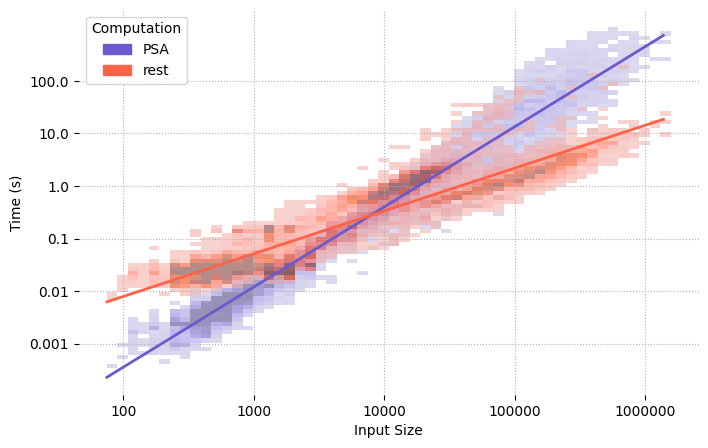

In [175]:
from sklearn.linear_model import LinearRegression

colors = [sn.color_palette("mako")[i] for i in [1, 3]]
colors = ["slateblue", "darkolivegreen"]

x_log = np.log10(plot_df["Input Size"])
y_log = np.log10(plot_df["Time (s)"])

plt.figure(figsize=(8, 5))
ax = sn.histplot(
    x=x_log,
    y=y_log,
    hue=plot_df["Computation"],
    palette=["slateblue", "tomato"],
    binwidth=0.08,
    alpha=0.6,
    common_norm=False,
    pthresh=0,
    pmax=0.7,
)
log_xticks = np.arange(2, 7)
log_yticks = np.arange(-3, 3)

plt.xlabel("Input Size")
plt.ylabel("Time (s)")
plt.xticks(log_xticks, labels=10**log_xticks)
plt.yticks(log_yticks, labels=10.0**log_yticks)

ax.grid(linestyle=":")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

sn.move_legend(ax, "upper left")

colors = ["slateblue", "tomato"]
for i, computation in enumerate(plot_df["Computation"].unique()):
    mask = plot_df["Computation"] == computation
    x_vals = x_log[mask].to_numpy().reshape(-1, 1)
    y_vals = y_log[mask].to_numpy()
    model = LinearRegression().fit(x_vals, y_vals)
    x_fit = np.linspace(x_vals.min(), x_vals.max(), 100).reshape(-1, 1)
    y_fit = model.predict(x_fit)
    ax.plot(x_fit.flatten(), y_fit, color=colors[i], lw=2, label=f"{computation} fit")


# plt.savefig(
#     ROOT.parent / "figures" / "computation_psa_vs_rest.svg", bbox_inches="tight"
# )

/tmp/ipykernel_1489560/1984594484.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = plt.gca().set_xticklabels(xticklabels, rotation=45)


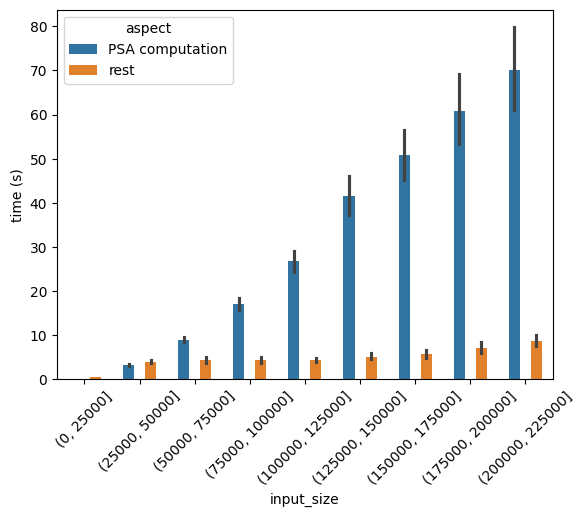

In [32]:
x = pd.cut(plot_df["input_size"], bins=np.arange(0, 250000, 25000))

sn.barplot(
    data=plot_df,
    x=x,
    y="time (s)",
    hue="aspect",
    gap=0.5,
    # flierprops={"marker": "x"},
)
xticklabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xticklabels, rotation=45)

/tmp/ipykernel_1489560/3529381834.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = plt.gca().set_xticklabels(xticklabels, rotation=45)


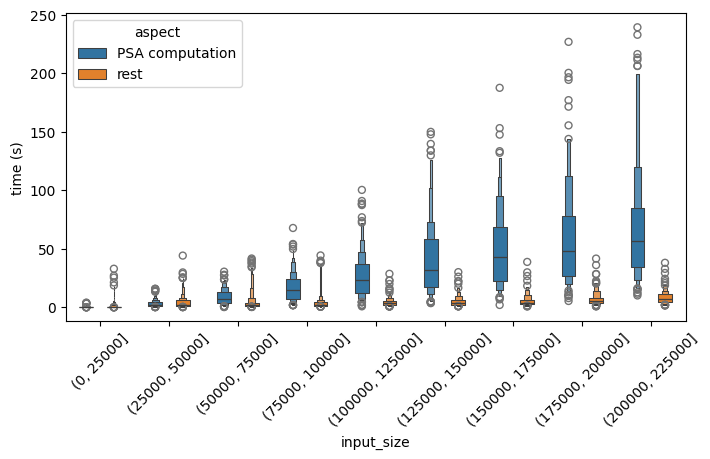

In [24]:
x = pd.cut(plot_df["input_size"], bins=np.arange(0, 250000, 25000))
fig = plt.figure(figsize=(8, 4))
sn.boxenplot(
    data=plot_df,
    x=x,
    y="time (s)",
    hue="aspect",
    gap=0.5,
    # flierprops={"marker": "x"},
)
# plt.yscale("log")
xticklabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xticklabels, rotation=45)